# Problem 1


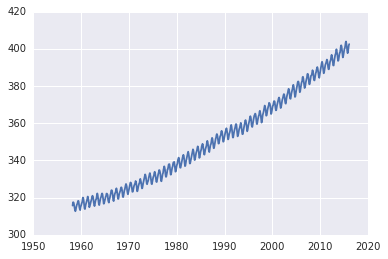

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# First download the data
import urllib
urllib.urlretrieve('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt', '../data/co2_mm_mlo.txt')
# Now we load it
data = np.loadtxt('../data/co2_mm_mlo.txt')
# This is time (measured in decimal dates)
t = data[:, 2][:, None]
# This the the CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
y = data[:, 4][:, None]
plt.plot(t, y)


In [19]:
X_p = np.linspace(2016, 2026, 100)[:, None]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#data = np.loadtxt('../data/motor.dat')
X = t
Y = y
#fig, ax = plt.subplots()
#ax.plot(X, Y, 'x', markeredgewidth=2)
#ax.set_xlabel('$x$')
#ax.set_ylabel('$y$')

In [31]:
# Implementation of the basis functions
class LinearBasis(object):
    """
    Represents a 1D linear basis.
    """
    def __init__(self):
        self.num_basis = 2 # The number of basis functions
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        return [1., x[0]]

In [32]:
# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

In [33]:
# Here is a class for the polynomials:
class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

In [34]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

best sigma: 3.75583742137
best alpha: [  1.00000000e+00   4.38460769e-01   9.05277320e+04   4.92352233e+05
   4.99999683e+05   2.61877640e+04]


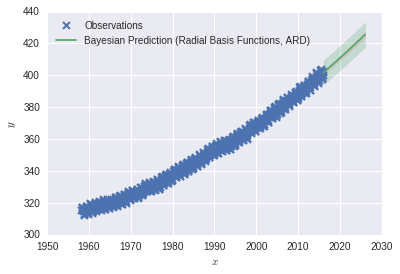

In [35]:
import scipy.linalg
from sklearn.linear_model import ARDRegression
ell = 2.
Xc = np.linspace(0, 60, 50)
#phi = RadialBasisFunctions(Xc, ell)

degree = 5
phi = PolynomialBasis(degree)

Phi = compute_design_matrix(X, phi)
regressor = ARDRegression()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print 'best sigma:', sigma
alpha = regressor.lambda_
print 'best alpha:', alpha
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, ARD)')
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')

I choose Polynomial basis function, because I expect CO2 level rises along the year and has increasing trend with respect to time. among suggested basis functions Polynomal ones have desirable behavior (Polynomials' value increase with increasing x) and the expected behavior van be reconstructed by collection of these functions.

# problem 2

In [4]:
import numpy as np
# Here is an amazing code:
solver = lambda(x): -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# It accepts just one input parameter that varies between 0 and 1


> writing model to file: surrogate.pcl


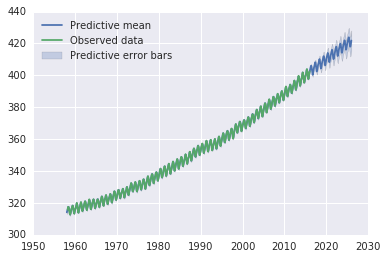

In [47]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn
import cPickle as pickle
import GPy

# Ensure reproducibility
np.random.seed(1345678)

# Select the number of simulations you want to perform:
num_sim = 10

# Generate the input data (needs to be column matrix)
#X = np.random.rand(num_sim, 1)

# Evaluate our amazing code at these points:
#Y = solver(X)


k1 = GPy.kern.RBF(input_dim=1, variance=10.0**2, lengthscale=40)
k2 = GPy.kern.RBF(input_dim=1, variance=2.0**2, lengthscale=100)
k3 = GPy.kern.PeriodicExponential(input_dim=1, variance=1., lengthscale=1., period=1.)
k4 = GPy.kern.RatQuad(input_dim=1, variance=10.**2, lengthscale=1)
k5 = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=.1)
k6 = GPy.kern.White(input_dim=1)


m = GPy.models.GPRegression(X, Y, k1+(k2*k3)+k4+k5+k6)



#m.likelihood.variance = 0.
#m.optimize()
#m.optimize_restarts(num_restarts=5, robust=True)
# That's it. Print some details about the model:


m['.*sum.RatQuad.variance'].constrain_fixed(0.25)
m['.*sum.mul.periodic_exponential.lengthscale'].constrain_fixed(1.)
m['.*sum.RatQuad.lengthscale'].constrain_fixed(1.)
m['.*sum.RatQuad.power'].constrain_fixed(2.)
m['.*sum.mul.periodic_exponential.variance'].constrain_fixed(1.)

#m.optimize()
m.optimize_restarts(num_restarts=100, robust=True)
#print m

# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(1958, 2026., 1000)[:, None]

# We can make predictions as follows
Y_p, V_p = m.predict(X_p) # Y_p = mean prediction, V_p = predictive variance
# Here is the standard deviation:
S_p = np.sqrt(V_p)
# Lower predictive bound
Y_l = Y_p - 2. * S_p
# Upper predictive bound
Y_u = Y_p + 2. * S_p

fig, ax = plt.subplots()
ax.plot(X_p, Y_p, label='Predictive mean')
ax.fill_between(X_p.flatten(), Y_l.flatten(), Y_u.flatten(), alpha=0.25, label='Predictive error bars')
ax.plot(X, Y, markeredgewidth=2, label='Observed data')
plt.legend(loc='best')
# Write the model to a file 
print '> writing model to file: surrogate.pcl'
with open('surrogate.pcl', 'wb') as fd:
    pickle.dump(m, fd)


# Problem 3


the best stochastic model for permeability is GP which provides us the ability to pin the unknown function at coordinates where we exactly have the prior information and we can precondition the probleem according to these information. 
in this problem I use transformed GP, becuase the value of permeability cannot be negative and log of this variable can get negative values. therefore, transformed version of GP can serve my purpose. the mean would be log of the values that we get from the geologist. I used Radial Basis Function (RBF) for covariance function and the effective parameteres include lengthscale and variance. 
$$
k(\mathbf{x}, \mathbf{x}') = v\exp\left\{-\frac{1}{2}\sum_{i=1}^d\frac{(x_i - x_i')^2}{\ell_i^2}\right\},
$$

In [5]:
import GPy
import numpy as np
import scipy
import GPy

class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum('i,ji,j,rj->ri', 1. / self.lam, self.v, self.wq, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

warning in stationary: failed to import cython module: falling back to numpy


# eigenfunction

Number of terms: 254


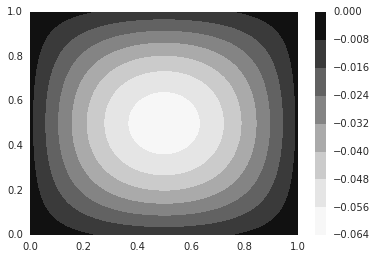

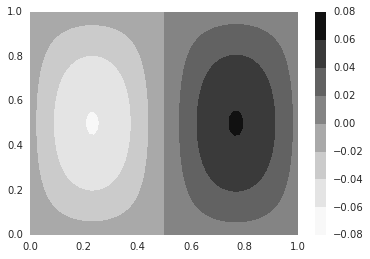

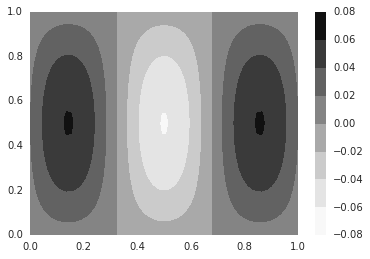

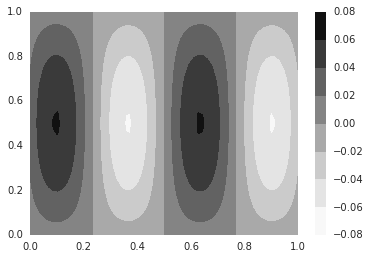

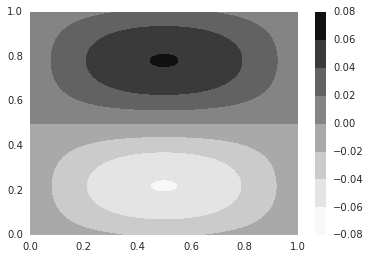

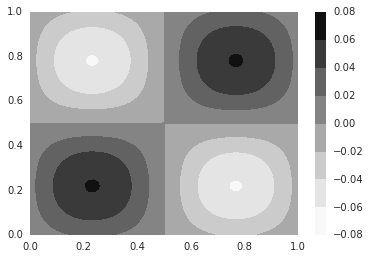

In [48]:
k = GPy.kern.RBF(2, ARD=True, variance=3.2**2, lengthscale=[10./356., 50./670.])
#X = np.random.rand(3, 2)
#Y = np.random.randn(3)
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=0.95)#, X=X, Y=Y)
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
Phi = kle.eval_phi(X_all)
for i in xrange(6):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
    plt.colorbar(c)


# eigenvalues

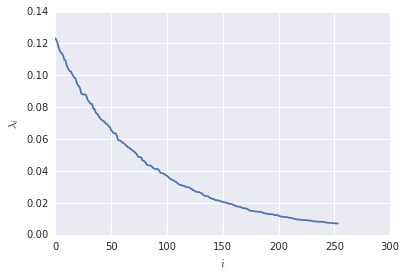

In [6]:

fig, ax = plt.subplots()
ax.plot(kle.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

# realizations

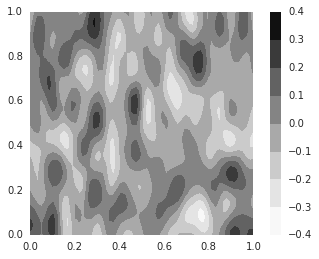

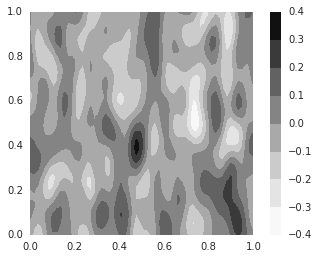

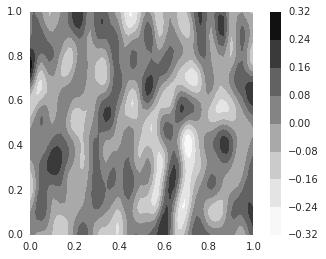

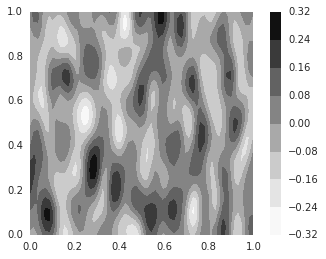

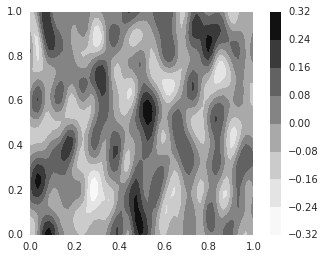

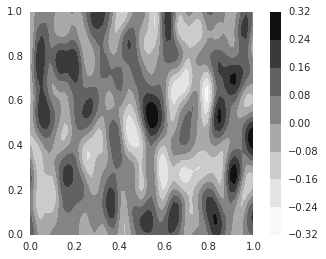

In [49]:
for i in xrange(6):
 xi = np.random.randn(kle.num_xi)
 f = kle(X_all, xi)
 fig, ax = plt.subplots()
 ax.set_aspect(1.)
 c = ax.contourf(X1, X2, f.reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
 plt.colorbar(c)

# loaded data

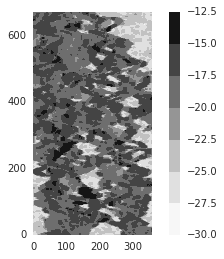

In [26]:
K = np.loadtxt('../data/spe10_permx.dat')
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)
fig, ax = plt.subplots()
c = plt.contourf(X1, X2, np.log(K).T)
ax.set_aspect(1.)
ax.locator_params(nbins=4)
plt.colorbar(c);

# sampled data

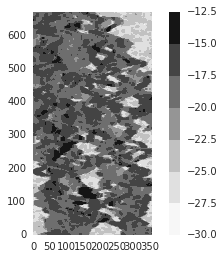

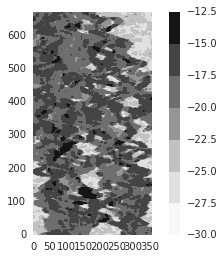

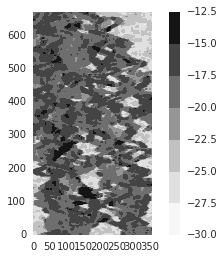

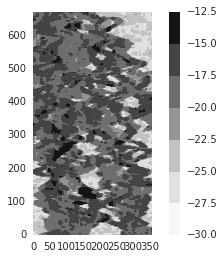

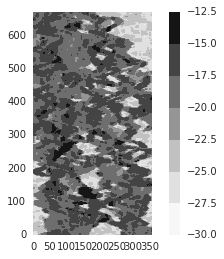

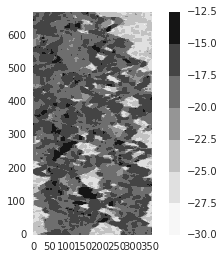

In [27]:
for i in xrange(6):
 xi = np.random.randn(kle.num_xi)
 f = kle(X_all, xi)
 fig, ax = plt.subplots()
 ax.set_aspect(1.)
 c = ax.contourf(X1, X2, np.log(K).T+f.reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
 plt.colorbar(c)

# problem 3.c


# eigenfunction

Number of terms: 253


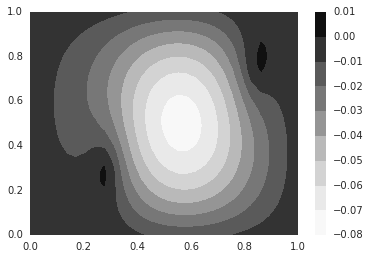

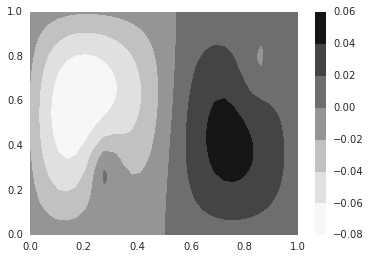

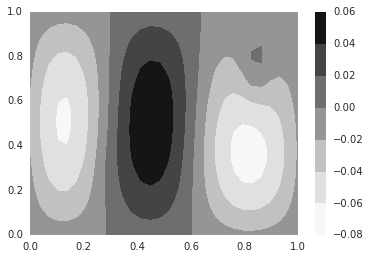

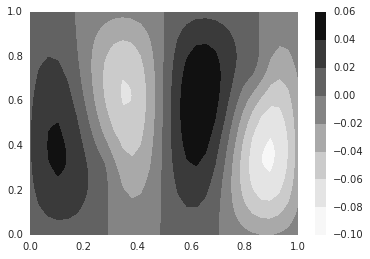

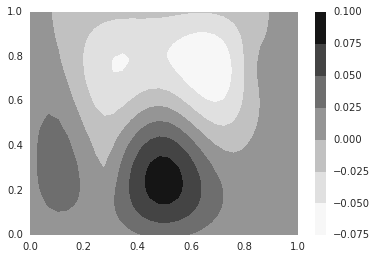

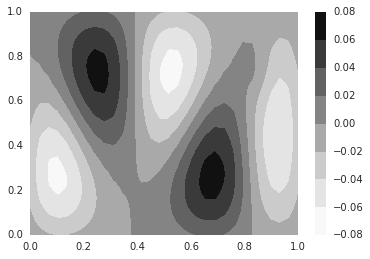

In [13]:
# Just generate some input/output pairs randomly...
import matplotlib.cm as pltt
X_a = np.ndarray((2, 2))
Y_a = np.ndarray((2,))
X_a[0,0]=100./356.
X_a[0,1]=200./670.
X_a[1,0]=300./356.
X_a[1,1]=500./670
#Y_a[0]=13.2
#Y_a[1]=-25.3
Y_a[0]=0.
Y_a[1]=0.
# X and Y are assumed to be observed

k = GPy.kern.RBF(2, ARD=True, variance=3.2**2, lengthscale=[10./356., 50./670.])
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=0.95, X=X_a, Y=Y_a)
x = np.linspace(0, 1, 100)[:, None]
x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 110)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
Phi = kle.eval_phi(X_all)
for i in xrange(6):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
    plt.colorbar(c)

# eigenvalues

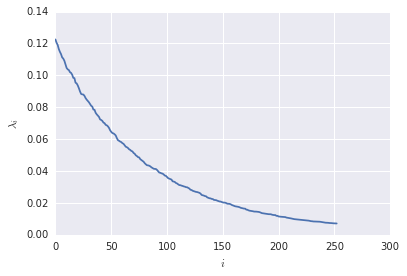

In [14]:
fig, ax = plt.subplots()
ax.plot(kle.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

# loaded data

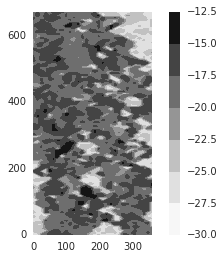

In [15]:
K = np.loadtxt('../data/spe10_permx.dat')
x1 = np.linspace(0, 356, 30)
x2 = np.linspace(0, 670, 110)
KK=np.zeros((30,110))
for i in xrange(30):
    for j in xrange(110):
        KK[i,j]=K[2*i,2*j]
        
X1, X2 = np.meshgrid(x1, x2)
fig, ax = plt.subplots()
c = plt.contourf(X1, X2, np.log(KK).T)
ax.set_aspect(1.)
ax.locator_params(nbins=4)
plt.colorbar(c);

# realization

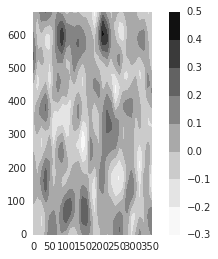

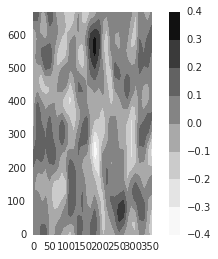

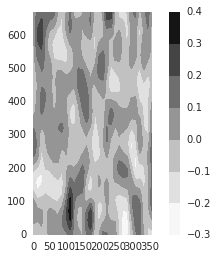

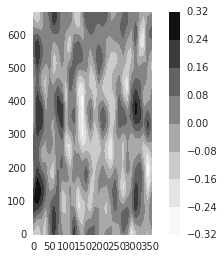

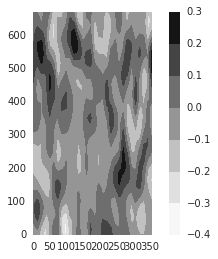

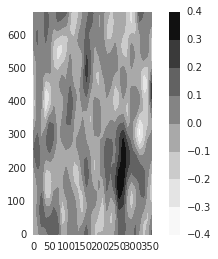

In [16]:
for i in xrange(6):
 xi = np.random.randn(kle.num_xi)
 f = kle(X_all, xi)
 fig, ax = plt.subplots()
 ax.set_aspect(1.)
 c = ax.contourf(X1, X2, f.reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
 plt.colorbar(c)

# sampled data

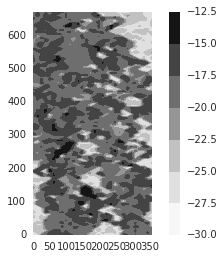

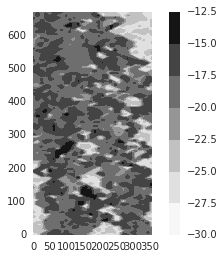

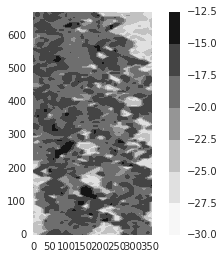

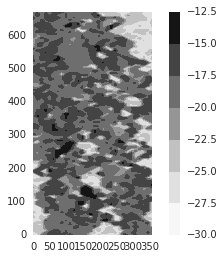

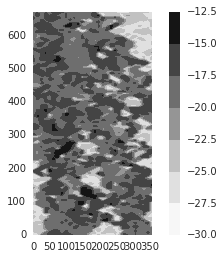

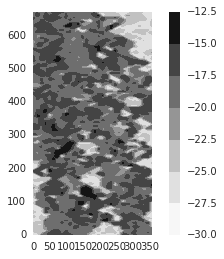

In [17]:
for i in xrange(6):
 xi = np.random.randn(kle.num_xi)
 f = kle(X_all, xi)
 fig, ax = plt.subplots()
 ax.set_aspect(1.)
 c = ax.contourf(X1, X2, np.log(KK).T+f.reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
 plt.colorbar(c)